In [1]:
import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from IPython.display import clear_output


from PIL import Image
import cv2


In [8]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
#이미지 주어진 크기에 따라 랜덤으로 분할,
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [10]:
# "-1 <= image <= 1" 로 변환
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [11]:
#이미지 변환 처리 중..
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [12]:
def preprocess_image_train_nl(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [13]:
class imagedata:
  def __init__(self, path,  w = 128, h = 192):
    self.outp = Image.open(path).convert("RGB")
    
    self.outp = self.outp.resize((w, h))
    area = (0, 0, int(w/4), int(h/4))
    self.inp = self.outp.crop(area)
    self.inp = self.inp.resize((w, h))
    self.oinp = self.inp
    self.ooutp = self.outp
    self.inp = np.array(self.oinp)
    self.outp = np.array(self.ooutp)
    self.inp = cv2.cvtColor(self.inp, cv2.COLOR_BGR2RGB)
    self.outp = cv2.cvtColor(self.outp, cv2.COLOR_BGR2RGB)
    self.inp = preprocess_image_train_nl(self.inp)
    self.outp = preprocess_image_train_nl(self.outp)

In [16]:
PATH_DIR='./Dataset/'
filelist = []

for i in [file for file in os.listdir(PATH_DIR) if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpge")]:
  filelist.append(imagedata(PATH_DIR + str(i)))

In [17]:
train_x = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype='float32')
train_y = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype='float32')

numi = 1
#for i in filelist:
  #print("인풋 배열 크기 : " + str(i.inp.shape))
  #print("아웃풋 배열 크기" + str(i.outp.shape))
  #train_x.append(i.inp)
  #print(str(numi) + "번째 이미지 로드 중..")
  
train_x = np.append(train_x, filelist[0].inp[np.newaxis], axis=0)
train_y = np.append(train_y, filelist[0].outp[np.newaxis], axis=0)

In [18]:
#이미지를 Generator을 통해서 "여름->겨울"로 변환하는 함수
def generate_images_r(model, test_input, real_output):
  prediction = model(test_input[np.newaxis])
  test_input1 = cv2.resize(test_input[np.newaxis][0], dsize=(128, 192), interpolation=cv2.INTER_AREA)
  prediction1 = cv2.resize(np.array(prediction[0]), dsize=(128, 192), interpolation=cv2.INTER_AREA)
  plt.figure(figsize=(12, 12))


  real_output1 = cv2.resize(real_output[np.newaxis][0], dsize=(128, 192), interpolation=cv2.INTER_AREA)
  display_list = [test_input1, prediction1, real_output1]
  title = ['Input Image', 'Predicted Image', 'Real Image']
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')

  
  plt.show()

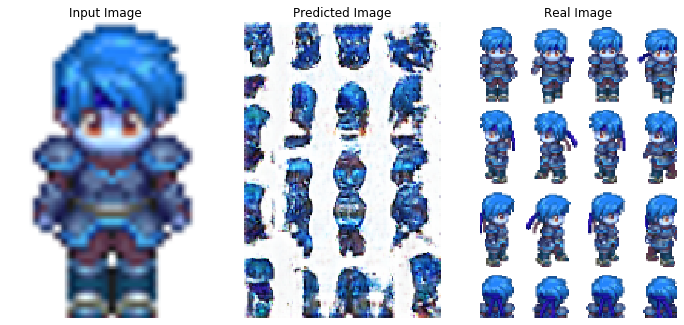

In [19]:
model = tf.keras.models.load_model('saved_model/generator_g')
generate_images_r(model, train_x[0], train_y[0])